In [1]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
#from src.algorithms import *
#import torch
import sklearn
%load_ext autoreload
import scipy

In [2]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

In [3]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [4]:
filename = "20231129_ 952.h5"
#filename = "2023811_1451.h5"
spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(filename)

# Pre-Processamento dos dados

In [5]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [6]:
lam = 1e2
p = 1e-1

pro_data = 1*spectrum_raman
for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        # print(i,j,end='\r')
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

100%|██████████| 120/120 [03:14<00:00,  1.62s/it]


In [7]:
pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        if sum_spec!=0:
            pro_data_norm[i,j,:]=spec/sum_spec
        else: 
            pro_data_norm[i,j,:]=0

In [8]:
offset_l = 31
offset_m = 328

mask = pro_data_norm[:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)

# threshold = 120
# threshold2 = 0.01

# # Scaled to max value for each wavenumber
# # masks = np.array([mask[:, i]*(mask[:, i] > threshold)/np.max(mask[:, i]) for i in range(mask.shape[-1])])
# masks = np.array([np.array((mask[:, i]/np.max(mask[:, i]))*((mask[:, i] > threshold)) > threshold2, dtype = int) for i in range(mask.shape[-1])])

# Threshold para diminuir o ruído

In [9]:
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])

Albite
Background
Background not found
Quartz
Muscovite
Lepidolite


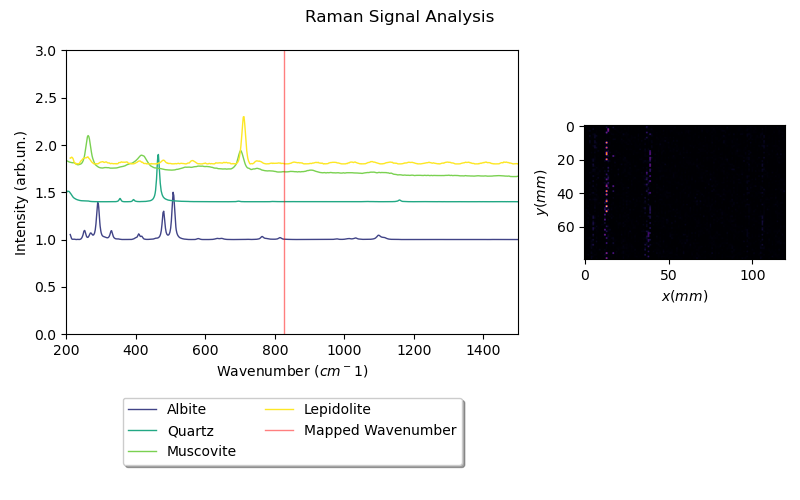

C:\Users\Joana\AppData\Local\Temp\ipykernel_1036\433690799.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])
C:\Users\Joana\AppData\Local\Temp\ipykernel_1036\433690799.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])
C:\Users\Joana\AppData\Local\Temp\ipykernel_1036\433690799.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])
C:\Users\Joana\AppData\Local\Temp\ipykernel_1036\433690799.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdat

In [14]:
%matplotlib widget
fig, ax = subplots(1, 2, figsize = (8, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('Raman Signal Analysis')

axs = ax[0]
minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    #'Petalite':[491.3],
    'Quartz':[463.92],
    #'Spodumene':[704.5]
    'Muscovite':[986],
    'Lepidolite':[707] 
    
}


mineral_list = list(minerals.keys())
for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        axs.plot(wl, 1 + 0.2*i + 0.5 * spec/np.max(spec), lw = 1, color = cm.viridis((i+1)/len(mineral_list)), label = mineral)
    except:
        print(mineral + ' not found')
axs.set_ylim(0,1+0.2*(i+1)+1)
axs.set_xlim(200,1500)
    
axs.legend(loc = 'upper right', bbox_to_anchor = (1.0, 1.0), ncol = 2, fancybox = True, shadow = True)
wn = 120
line = axs.axvline(wavelengths_raman[offset_l:offset_m][wn], lw = '1', alpha = 0.5, color = 'red', label = 'Mapped Wavenumber')
axs.set_xlabel(r'Wavenumber $(cm^-1)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.legend(loc='upper center', bbox_to_anchor = (0.5, -0.2), ncol = 2, fancybox = True, shadow = True)

axs = ax[1]
axs.imshow(mask_t.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(mask_t.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno,
                     interpolation = 'none')
    line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman[offset_l:offset_m], ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

# Clustering entre mapas com e sem informação

In [10]:
mask_t.shape

(297, 9600)

In [11]:
init_k=[0,1]
mask_min_max = np.array([(mask_t[i, :] - mask_t[i, :].min(axis = 0)+ 1e-5)/(mask_t[i, :].max(axis = 0) - mask_t[i, :].min(axis = 0) + 1e-5) for i in range(mask_t.shape[0])])
# mask_min_max = np.array([(mask_t[i, :])/(mask_t[i, :].max(axis = 0) + 1e-10) for i in range(mask_t.shape[0])])
masks = np.array([sklearn.cluster.KMeans(n_clusters = 2, random_state = 100).fit_predict(mask_min_max[i, :].reshape(-1, 1)) for i in range(mask_min_max.shape[0])])

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\clust

In [12]:
def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])

Albite
Background
Background not found
Quartz
Muscovite
Lepidolite


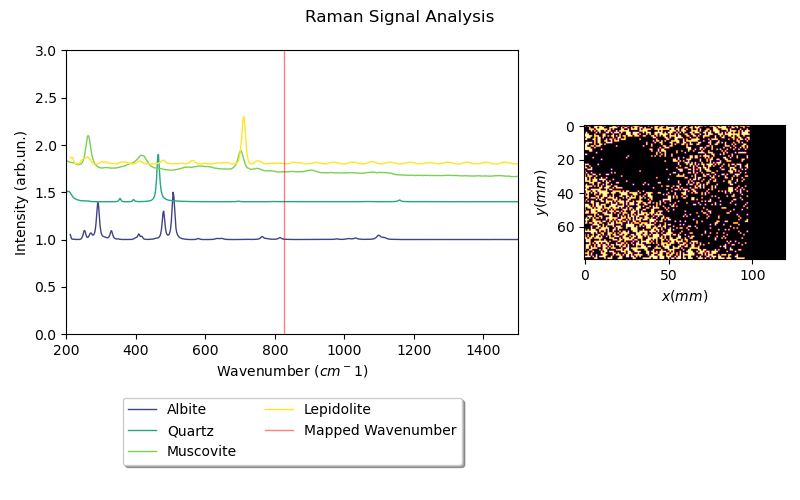

C:\Users\Joana\AppData\Local\Temp\ipykernel_1036\651272957.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])
C:\Users\Joana\AppData\Local\Temp\ipykernel_1036\651272957.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])
C:\Users\Joana\AppData\Local\Temp\ipykernel_1036\651272957.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])
C:\Users\Joana\AppData\Local\Temp\ipykernel_1036\651272957.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdat

In [13]:
%matplotlib widget
fig, ax = subplots(1, 2, figsize = (8, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('Raman Signal Analysis')

axs = ax[0]
minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    #'Petalite':[491.3],
    'Quartz':[463.92],
    #'Spodumene':[704.5]
    'Muscovite':[986],
    'Lepidolite':[707] 
    
}


mineral_list = list(minerals.keys())
for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        axs.plot(wl, 1 + 0.2*i + 0.5 * spec/np.max(spec), lw = 1, color = cm.viridis((i+1)/len(mineral_list)), label = mineral)
    except:
        print(mineral + ' not found')
axs.set_ylim(0,1+0.2*(i+1)+1)
axs.set_xlim(200,1500)
    
axs.legend(loc = 'upper right', bbox_to_anchor = (1.0, 1.0), ncol = 2, fancybox = True, shadow = True)
wn = 120
line = axs.axvline(wavelengths_raman[offset_l:offset_m][wn], lw = '1', alpha = 0.5, color = 'red', label = 'Mapped Wavenumber')
axs.set_xlabel(r'Wavenumber $(cm^-1)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.legend(loc='upper center', bbox_to_anchor = (0.5, -0.2), ncol = 2, fancybox = True, shadow = True)

axs = ax[1]
axs.imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno,
                     interpolation = 'none')
    line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman[offset_l:offset_m], ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

# Clustering final

In [13]:

kmeans = sklearn.cluster.KMeans(n_clusters = 6)
a=kmeans.fit_predict(masks)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [14]:
# labels = kmeans.labels_.cpu()
labels = kmeans.labels_

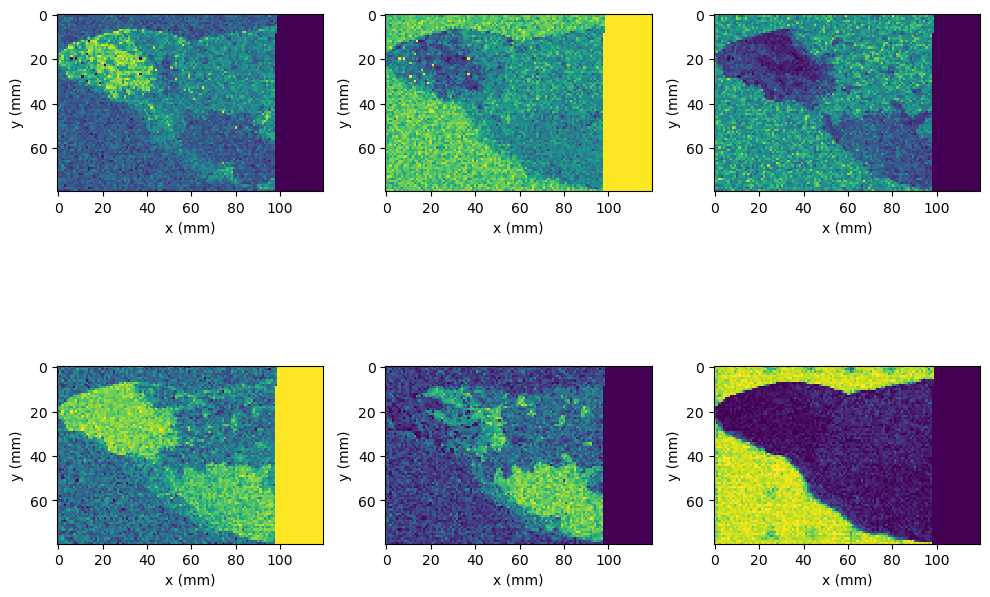

In [15]:

fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

## Cálculo da entropia

In [16]:
mask_min_max=scipy.ndimage.gaussian_filter(mask_min_max,sigma=0.5)

In [17]:
print(mask_min_max.shape)
entropy_masks=np.array([mask_min_max[i,:]*255 for i in range(297)])

(297, 9600)


In [18]:
entropy_masks[10]

array([ 8.65114119, 22.2769563 , 11.78354258, ...,  0.29780936,
        0.29780936,  0.29780936])

In [19]:
def entropy_calc(map_gr):
    import cv2
    from scipy.stats import entropy

    #image

    _bins = 200

    hist, _ = np.histogram(map_gr, bins=_bins, range=(0, _bins))

    prob_dist = hist / hist.sum()
    image_entropy = entropy(prob_dist, base=2)
    return image_entropy

In [20]:
offset_l = 31
offset_m = 328
wavelengths_raman.shape
wavelengths=wavelengths_raman[offset_l:offset_m]

minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Quartz':[463.92],
    'Muscovite':[986],
    'Lepidolite':[707] 
    
}

mineral_list = list(minerals.keys())

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))

significant_w=[]
for i,mineral in enumerate(mineral_list):
    wn=find_index(wavelengths,minerals[mineral][0])
    significant_w.append(wn)

In [21]:
image_entropy=[]
for i in range(297):
    map_gr=entropy_masks[i]
    image_entropy.append(entropy_calc(map_gr))


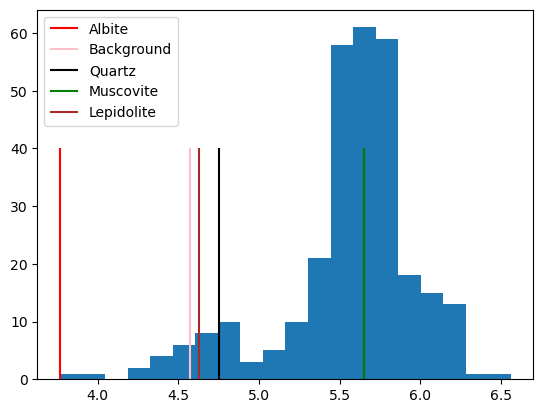

In [22]:
plt.hist(image_entropy,bins=20)
colors=['red','pink','black','green','brown']
for i in range(len(significant_w)):
    plt.vlines(image_entropy[significant_w[i]],0,40,color=colors[i],label=mineral_list[i])
    
plt.legend()

In [23]:

for i in significant_w:
    print(image_entropy[i]) #entropia dos mapas que têm informação dos minerais

3.767191449320589
4.575100624674791
4.754896127041122
5.65022903469184
4.6284559236056895


In [24]:
a=np.array(image_entropy)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

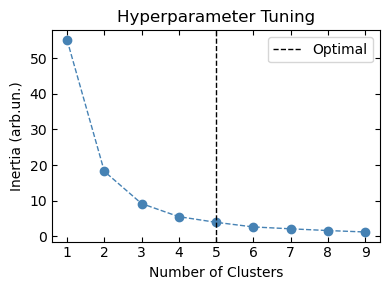

In [25]:
import sklearn
from sklearn import cluster

ncs = [i for i in range(1,10)]
inertias = []
for n_clusters in ncs:
    model = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=0)
    model.fit(a.reshape(-1, 1))
    inertias.append(model.inertia_)

fig,ax = plt.subplots(figsize=[4,3])
ax.set_title('Hyperparameter Tuning')
ax.plot(ncs, inertias, marker = 'o', color='steelblue', lw=1,ls='--')
ax.axvline(5,color='k',lw=1,ls='--',label='Optimal')
ax.legend()
ax.set_xlabel('Number of Clusters')
ax.set_xticks(ncs)
ax.set_ylabel('Inertia (arb.un.)')
ax.tick_params(axis='both',direction="in",top=True,right=True)
fig.tight_layout()


In [26]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5)
pred_entropy=kmeans.fit_predict(a.reshape(-1, 1))

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [27]:
pred_entropy

array([3, 1, 1, 3, 3, 1, 2, 2, 4, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4, 2,
       1, 1, 3, 3, 3, 3, 1, 2, 0, 2, 1, 1, 2, 4, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 0, 4,
       4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 2, 2, 2, 2, 1, 1, 3, 1, 2,
       2, 2, 1, 1, 1, 4, 0, 0, 2, 3, 1, 2, 1, 1, 3, 1, 1, 1, 2, 2, 4, 4,
       4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 2, 4, 4, 2, 2, 4, 2,
       4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2,
       2, 2, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4,
       4, 4, 2, 2, 2, 2, 4, 4, 4, 4, 2, 4, 4, 4, 0, 0, 4, 4, 0, 4, 4, 4,
       2, 2, 2, 2, 2, 4, 0, 0, 0, 0, 4, 2, 2, 2, 2, 4, 2, 2, 2, 4, 0, 0,
       0, 0, 4, 2, 4, 4, 0, 0, 0, 4, 4, 2, 2, 4, 2, 2, 2, 2, 4, 4, 0, 0,
       0, 0, 0, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 0, 0, 0,
       0, 0, 0, 4, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 4, 2,
       2, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4])

In [28]:
for i in range(len(significant_w)):
    print(pred_entropy[significant_w[i]],mineral_list[i])

3 Albite
3 Background
1 Quartz
4 Muscovite
1 Lepidolite


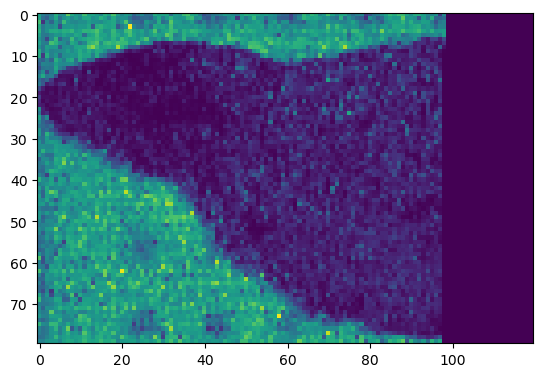

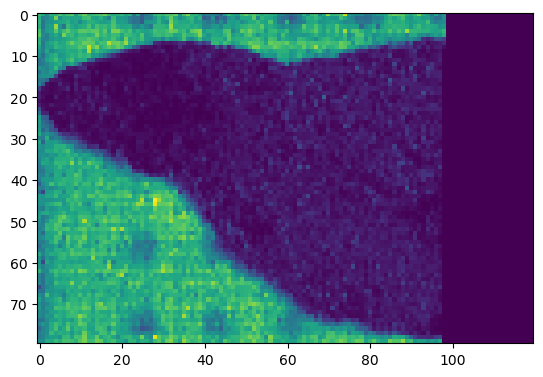

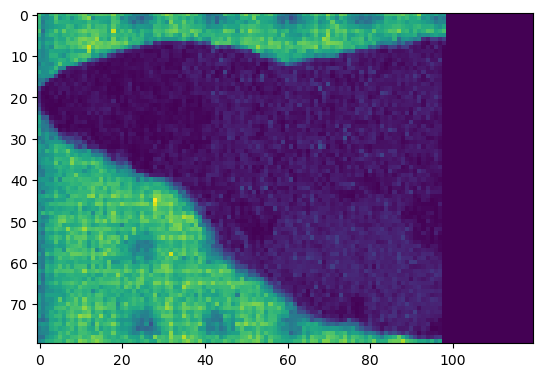

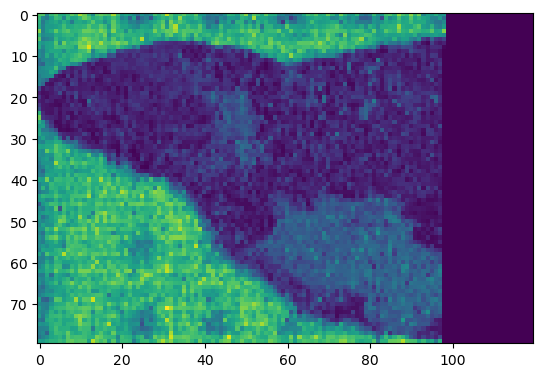

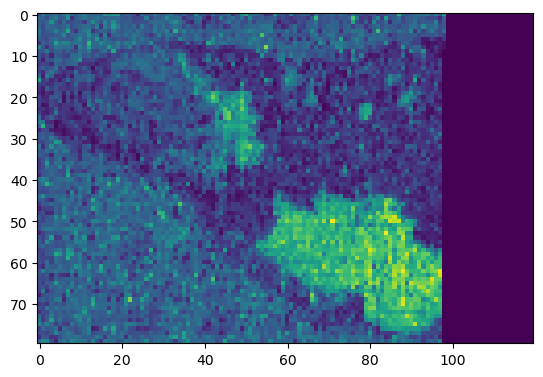

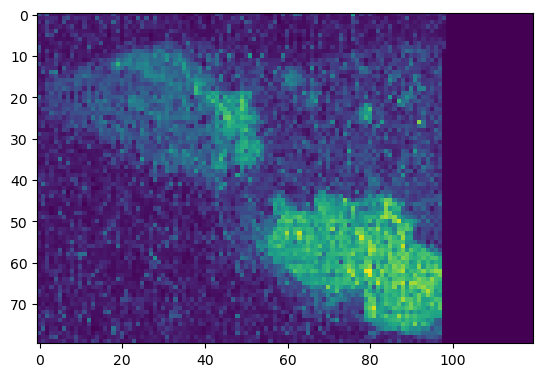

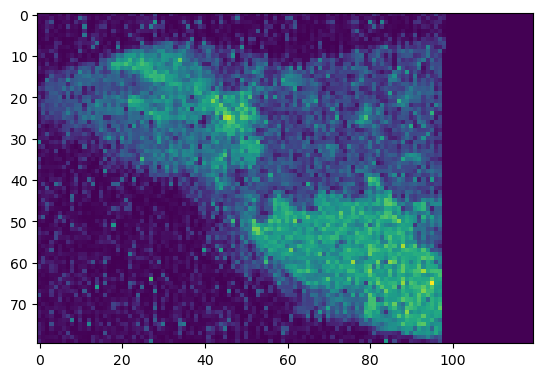

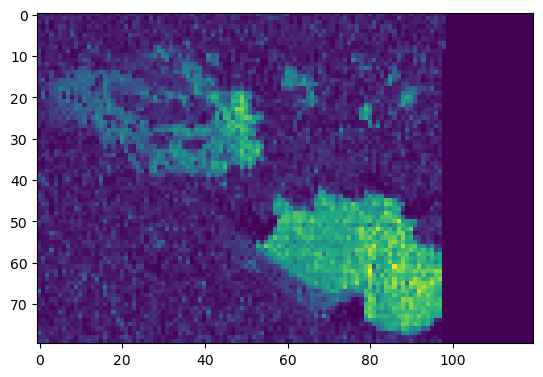

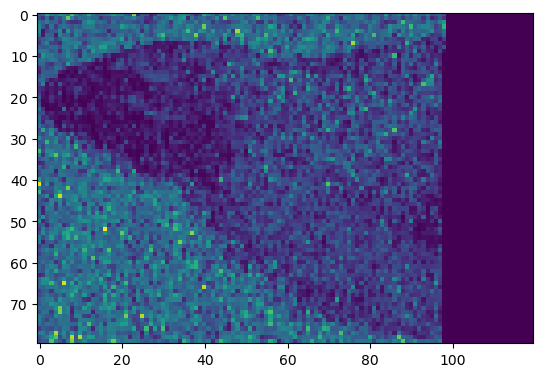

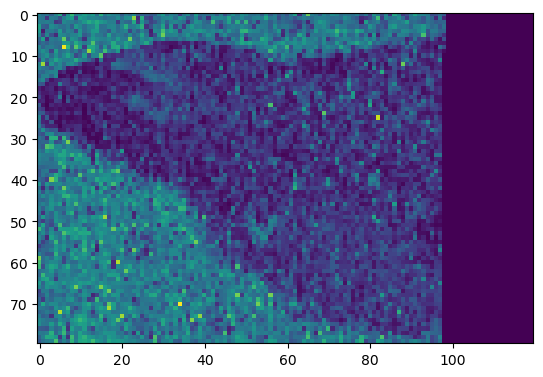

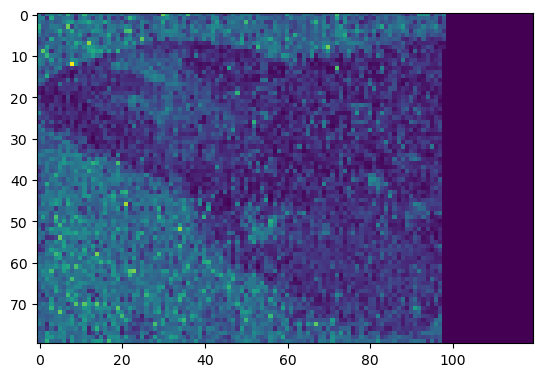

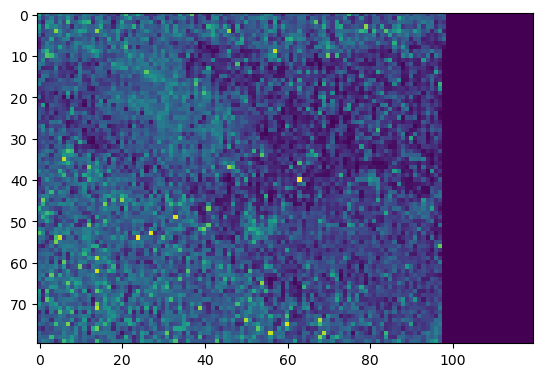

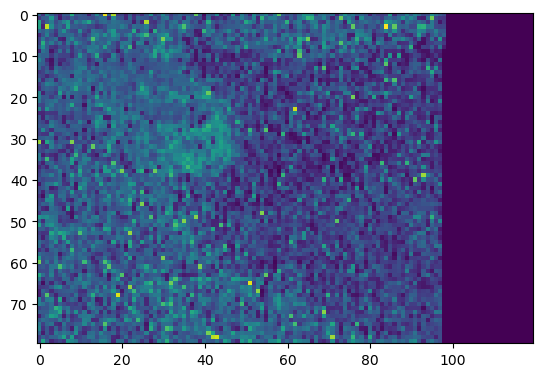

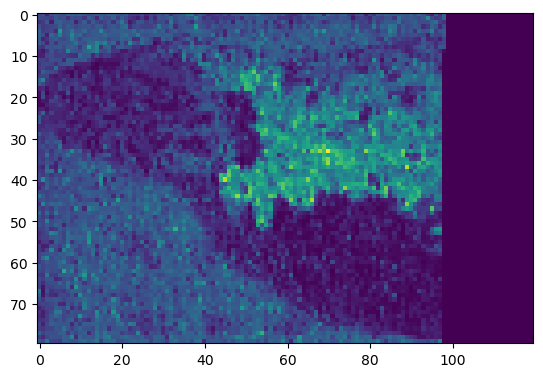

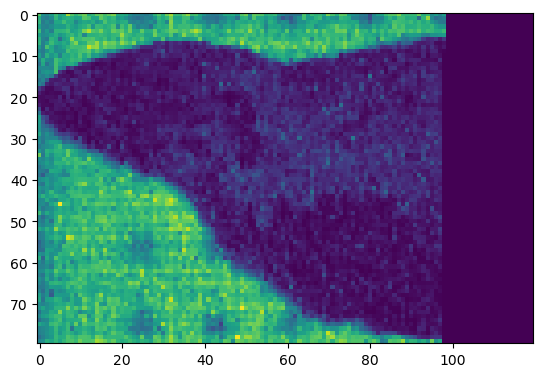

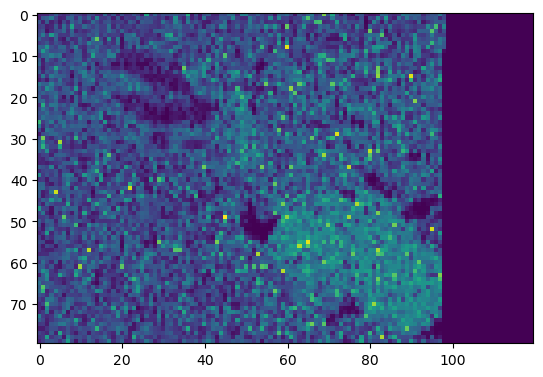

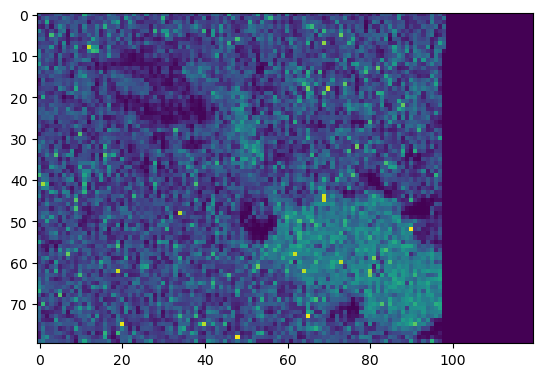

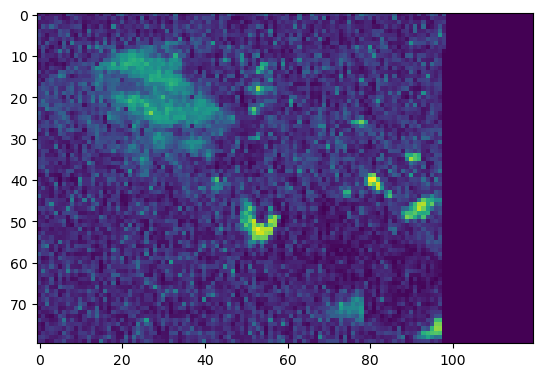

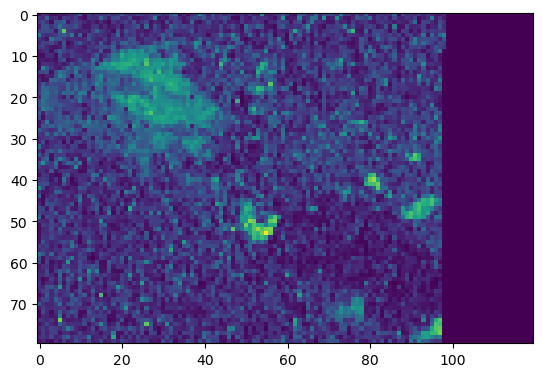

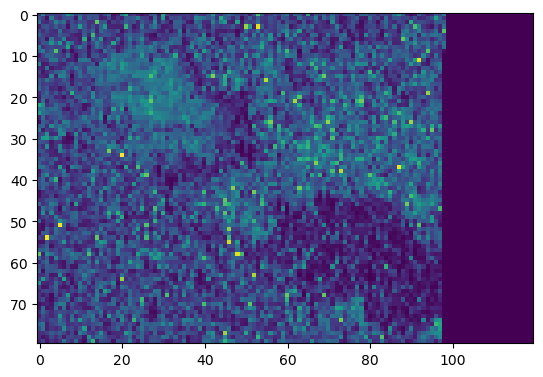

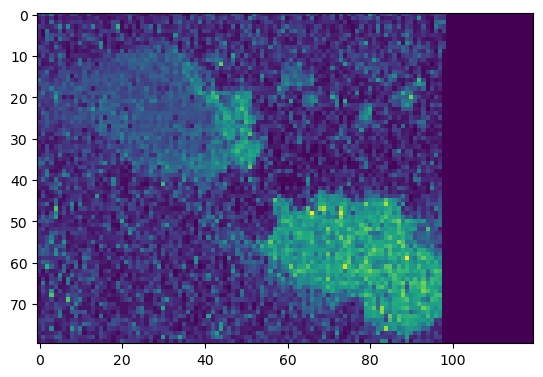

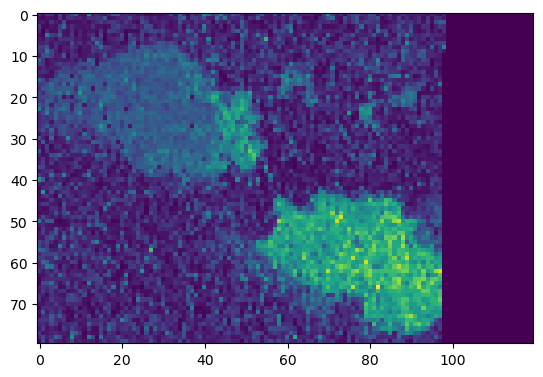

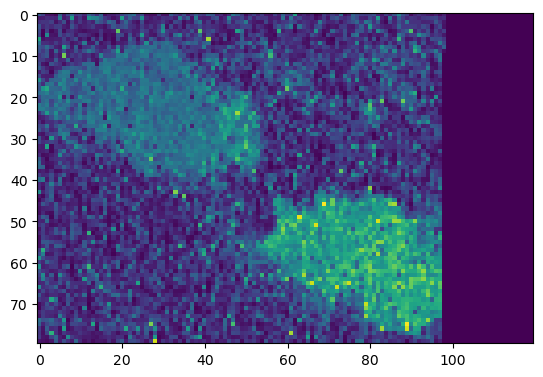

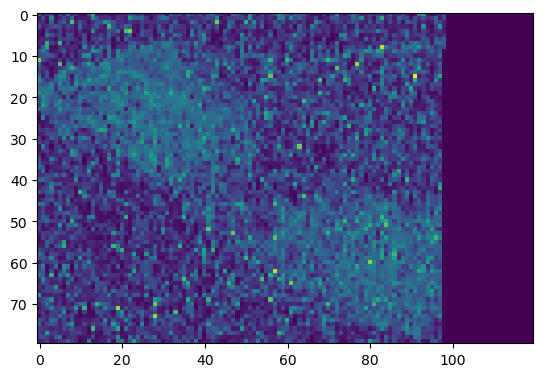

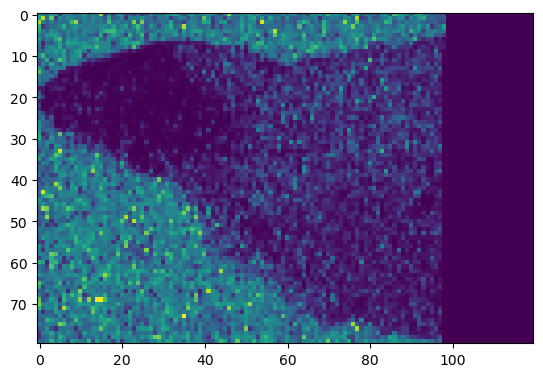

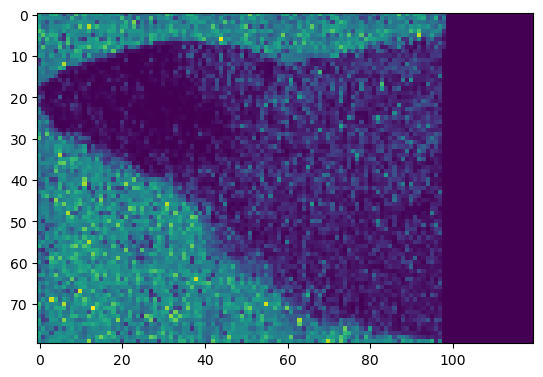

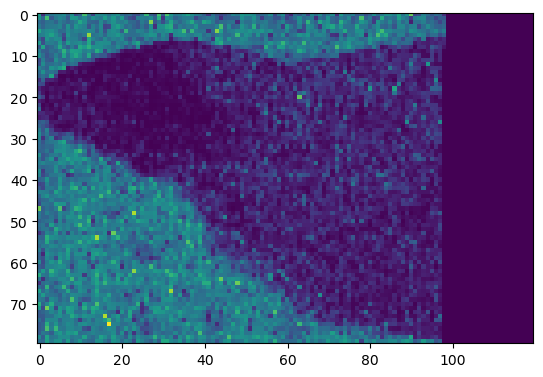

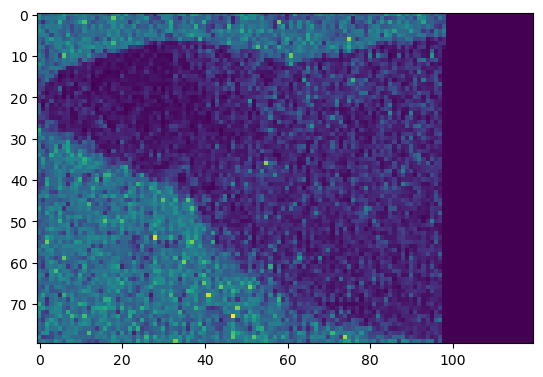

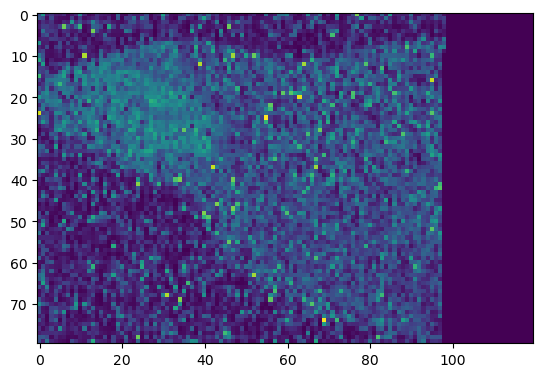

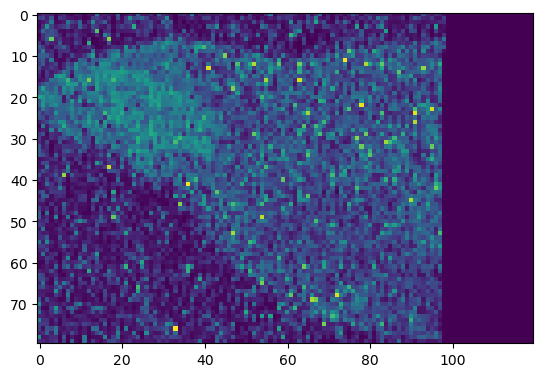

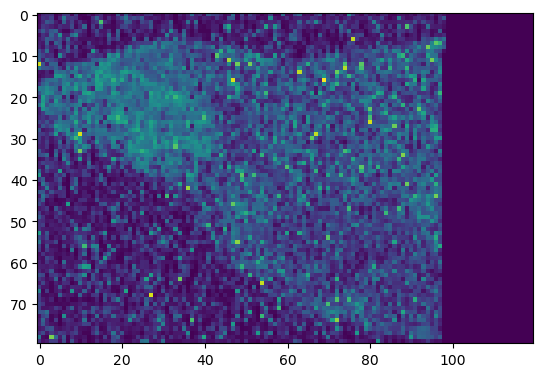

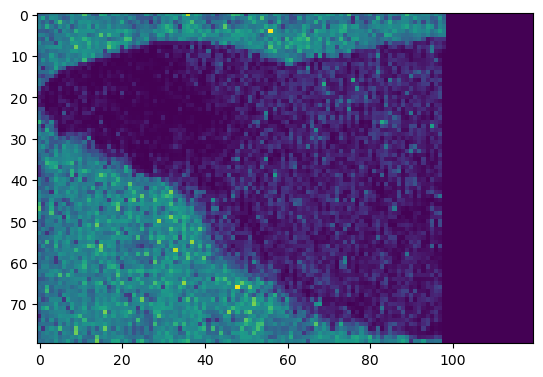

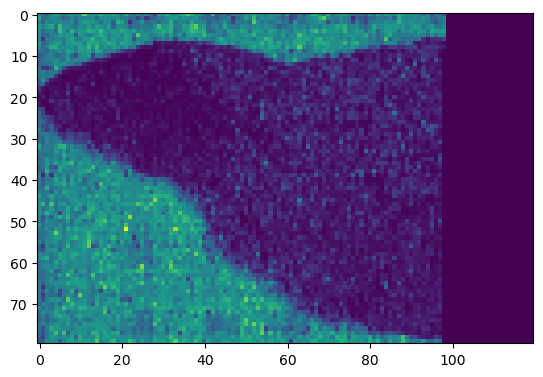

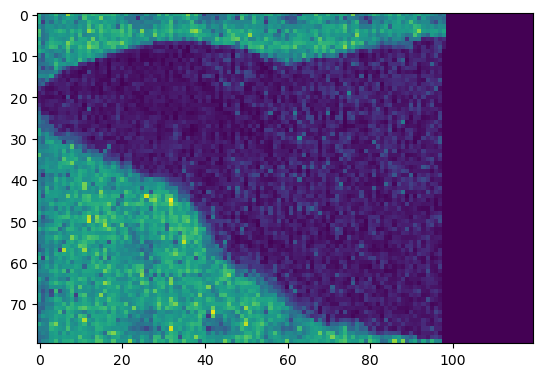

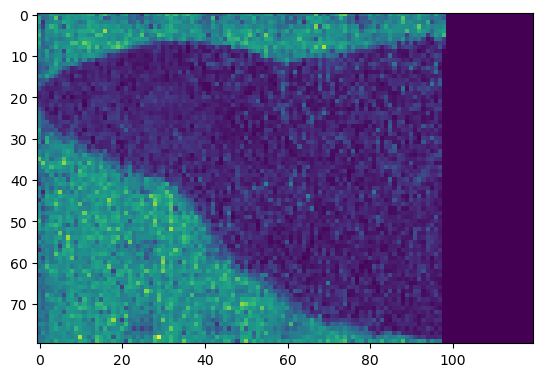

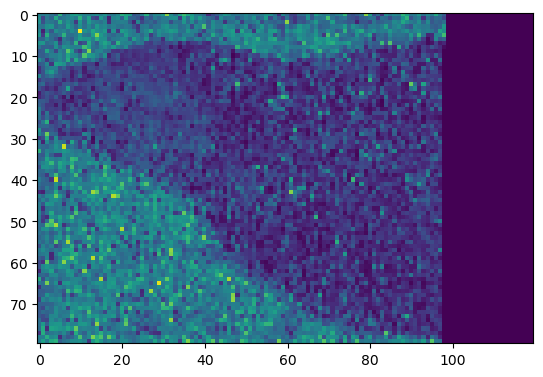

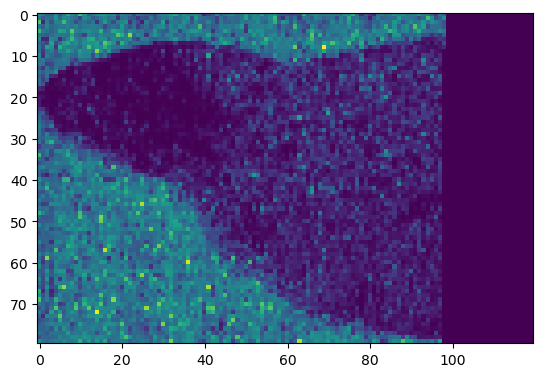

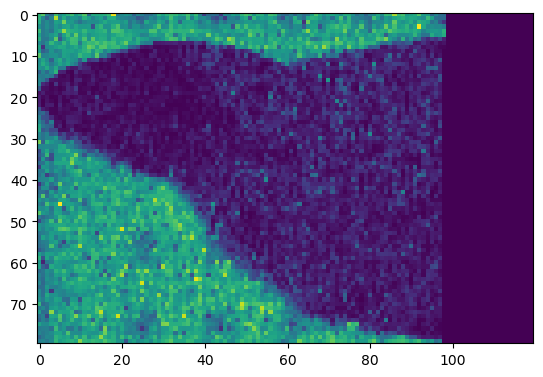

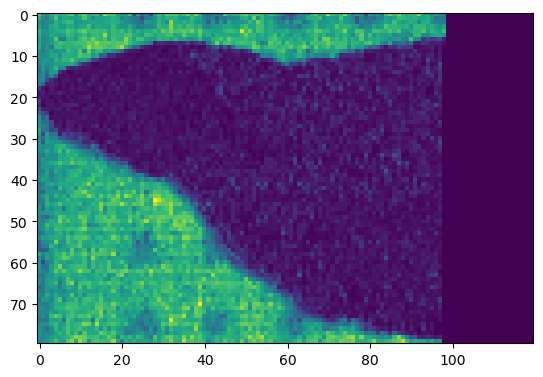

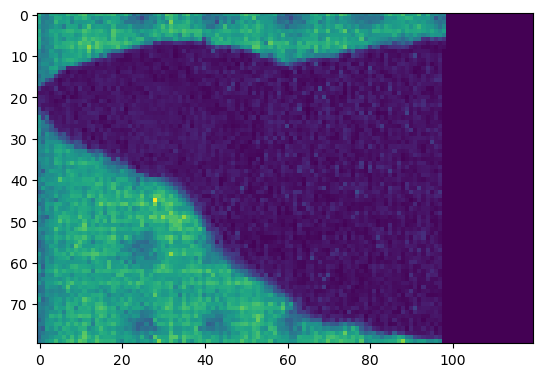

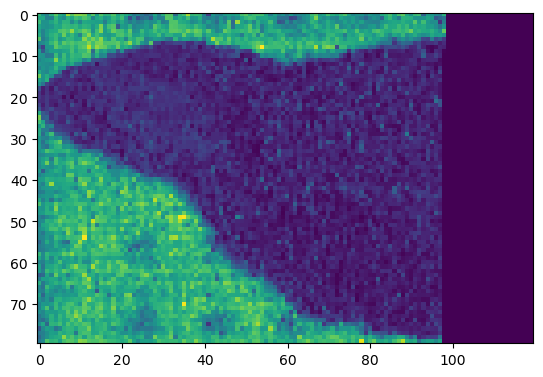

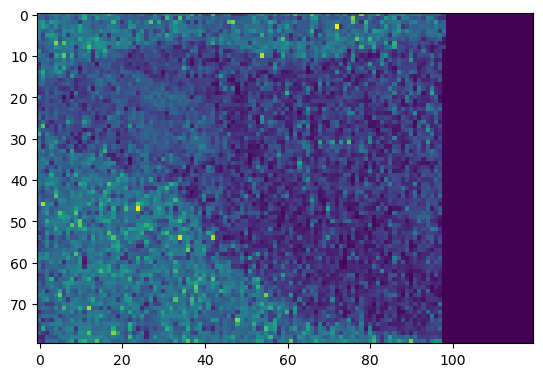

In [29]:
count=0
new_maps=[]
for i in range(len(pred_entropy)):
    if pred_entropy[i]==0:
        count+=1
        new_maps.append(entropy_masks[i,:])
        plt.imshow(entropy_masks[i,:].reshape(pro_data.shape[0], pro_data.shape[1]).T)
        plt.show()

In [30]:
print(count)

42


c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


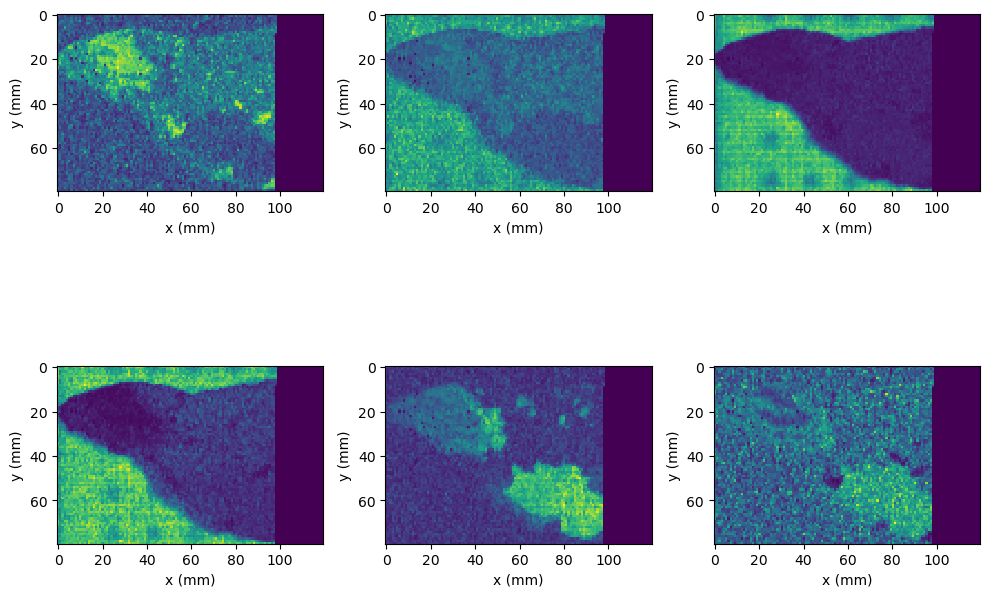

In [31]:
kmeans = sklearn.cluster.KMeans(n_clusters = 6)
a=kmeans.fit_predict(new_maps)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

## mapas com entropias entre as entropias dos mapas com minerais

In [32]:
relevant_entropies=[]
for i in significant_w:
    relevant_entropies.append(image_entropy[i])
    
max_en=np.max(relevant_entropies)
min_en=np.min(relevant_entropies)

new_maps_cut=[]
for i in range(entropy_masks.shape[0]):
    if min_en<=image_entropy[i]<=max_en:
        new_maps_cut.append(entropy_masks[i,:])
        
new_maps_cut=np.array(new_maps_cut)


In [33]:
new_maps_cut.shape

(155, 9600)

In [34]:
import os
folder_name='plots_entropias_medias'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    

for i in range(new_maps_cut.shape[0]):
    # Save the figure to the folder
    plt.imshow(new_maps_cut[i].reshape(250,100))
    file_path = os.path.join(folder_name, f'plot_med_{i}.png')
    plt.savefig(file_path)

    # Close the current figure to prevent it from being displayed
    plt.close()

ValueError: cannot reshape array of size 9600 into shape (250,100)

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 6)
a=kmeans.fit_predict(new_maps_cut)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

## usar só mapas com entropia maior que a do mineral com menor entropia

In [ ]:
relevant_entropies=[]
for i in significant_w:
    relevant_entropies.append(image_entropy[i])
    
min_en=np.min(relevant_entropies)

new_maps_cut=[]
for i in range(entropy_masks.shape[0]):
    if min_en<=image_entropy[i]:
        new_maps_cut.append(entropy_masks[i,:])
        
new_maps_cut=np.array(new_maps_cut)


In [ ]:
import os
folder_name='plots_entropias_altas'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    

for i in range(new_maps_cut.shape[0]):
    # Save the figure to the folder
    plt.imshow(new_maps_cut[i].reshape(250,100))
    file_path = os.path.join(folder_name, f'plot_med_{i}.png')
    plt.savefig(file_path)

    # Close the current figure to prevent it from being displayed
    plt.close()

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 6)
a=kmeans.fit_predict(new_maps_cut)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

## usar só mapas com entropia menor do que a do mineral com maior entropia

In [ ]:

new_maps_cut=[]
for i in range(entropy_masks.shape[0]):
    if image_entropy[i]<=max_en:
        new_maps_cut.append(entropy_masks[i,:])
        
new_maps_cut=np.array(new_maps_cut)

kmeans = sklearn.cluster.KMeans(n_clusters = 6)
a=kmeans.fit_predict(new_maps_cut)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

In [ ]:
import os
folder_name='plots_entropias_baixas'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    

for i in range(new_maps_cut.shape[0]):
    # Save the figure to the folder
    plt.imshow(new_maps_cut[i].reshape(250,100))
    file_path = os.path.join(folder_name, f'plot_med_{i}.png')
    plt.savefig(file_path)

    # Close the current figure to prevent it from being displayed
    plt.close()

## Entropias intermédias é a que mantém mais informação - ajustar a gama

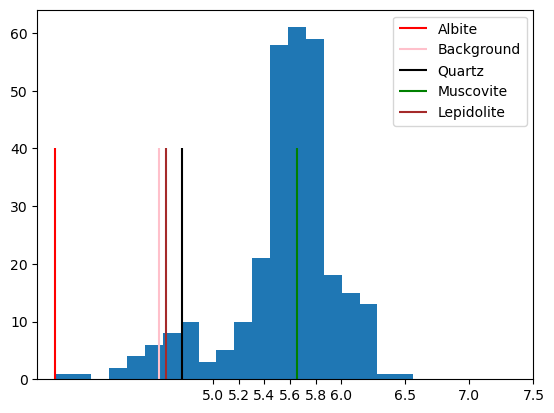

In [ ]:
plt.hist(image_entropy,bins=20)
colors=['red','pink','black','green','brown']
for i in range(len(significant_w)):
    plt.vlines(image_entropy[significant_w[i]],0,40,color=colors[i],label=mineral_list[i])
    
plt.xticks([5,5.2,5.4,5.6,5.8,6,6.5,7,7.5])
    
plt.legend()

In [ ]:
relevant_entropies=[]
for i in significant_w:
    relevant_entropies.append(image_entropy[i])
    
max_en=np.max(relevant_entropies)
min_en=np.min(relevant_entropies)

new_maps_cut=[]
for i in range(entropy_masks.shape[0]):
    if min_en<=image_entropy[i]<=max_en:
        new_maps_cut.append(entropy_masks[i,:])
        
new_maps_cut=np.array(new_maps_cut)


C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


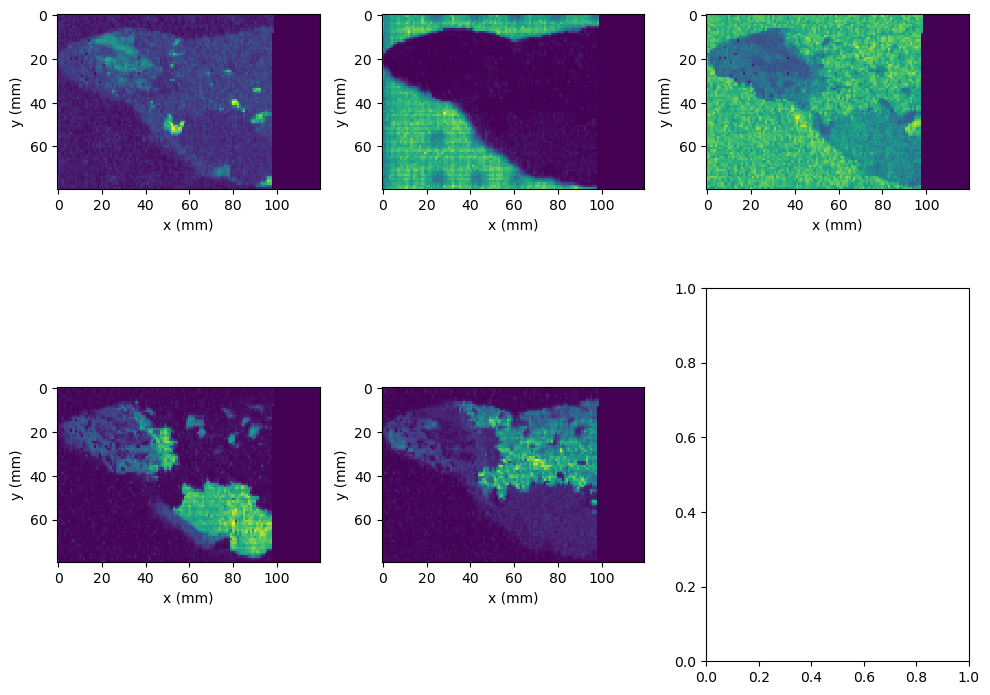

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5)
a=kmeans.fit_predict(new_maps_cut)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

In [ ]:
maps=new_maps_cut

In [ ]:
print(maps.shape)
print(maps[100])

(155, 9600)
[18.54776379 22.32445419 23.15503328 ...  0.37167519  0.37167519
  0.37167519]


## Entropy equalization

In [ ]:
#P=maps.mean(axis=0)
#P=np.random.random(25000)*255
P=maps[significant_w[0]]
P.sort()
final_masks=[]
for i in range(maps.shape[0]):
    X=maps[i].copy()
    #X.sort()
    sorted_args=X.argsort()
    new_X=np.ones(maps.shape[1])
    for j in range(maps.shape[1]):
        #new_X[j]=float(P[sorted_args[j]])
        new_X[sorted_args[j]]=P[j]
        
    #print(new_X)
    final_masks.append(new_X)
final_masks=np.array(final_masks)

In [ ]:
print(entropy_calc(final_masks[12,:]))

5.358027896426362


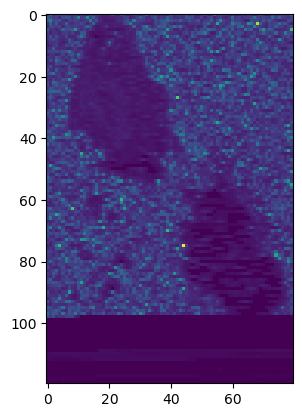

In [ ]:
imshow(final_masks[13].reshape(pro_data.shape[0], pro_data.shape[1]))


### classificação

C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


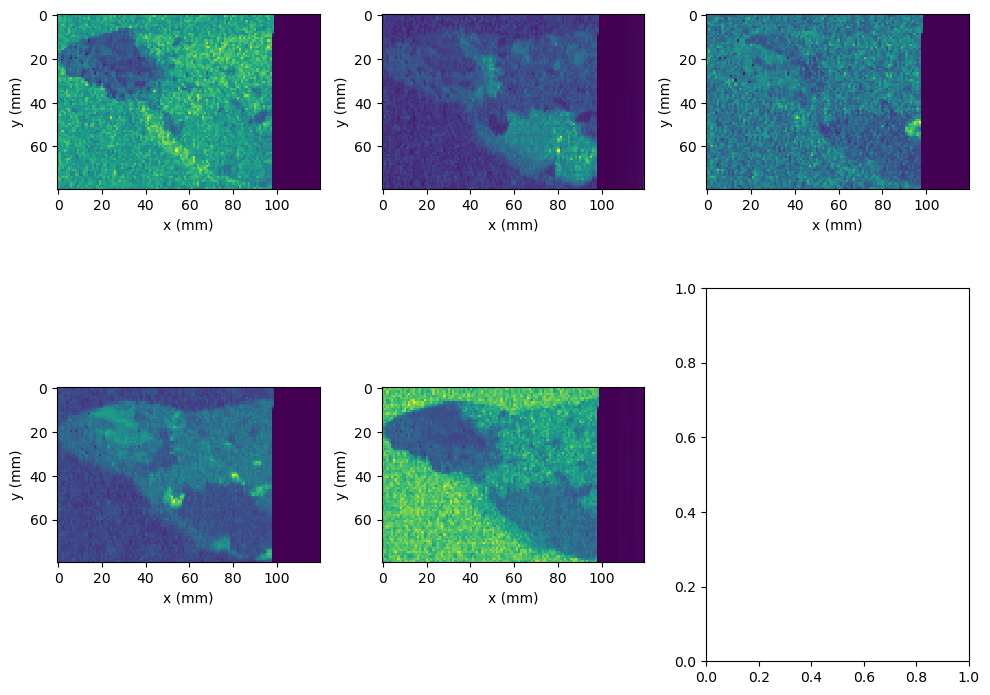

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5)
a=kmeans.fit_predict(final_masks)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

## inicialização com matrizes

## cortar o background

In [ ]:
maps=new_maps_cut

In [ ]:
reshaped_maps=maps.reshape(-1,pro_data.shape[0], pro_data.shape[1])

In [ ]:
reshaped_maps.shape

(155, 120, 80)

In [ ]:
maps_without_background_1=reshaped_maps[:,0:90,10:75]
maps_without_background=maps_without_background_1.reshape(maps_without_background_1.shape[0],maps_without_background_1.shape[1]*maps_without_background_1.shape[2])


## classificação

C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


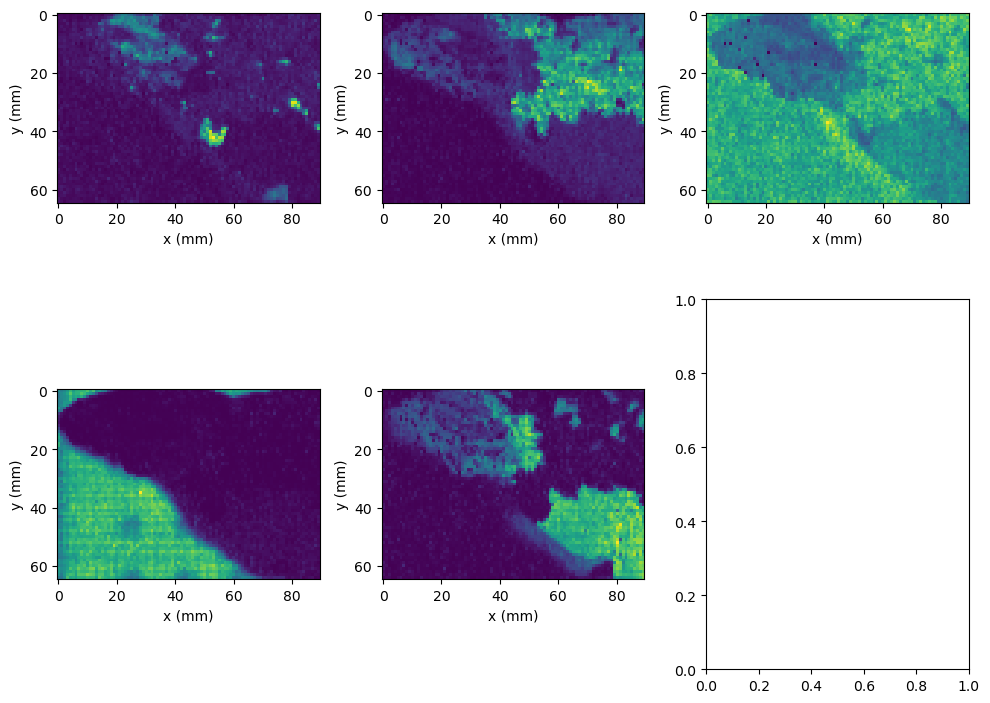

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5)
a=kmeans.fit_predict(maps_without_background)
labels = kmeans.labels_
fig, ax = subplots(2, 3,figsize=(10,8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(maps_without_background_1.shape[1], maps_without_background_1.shape[2]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


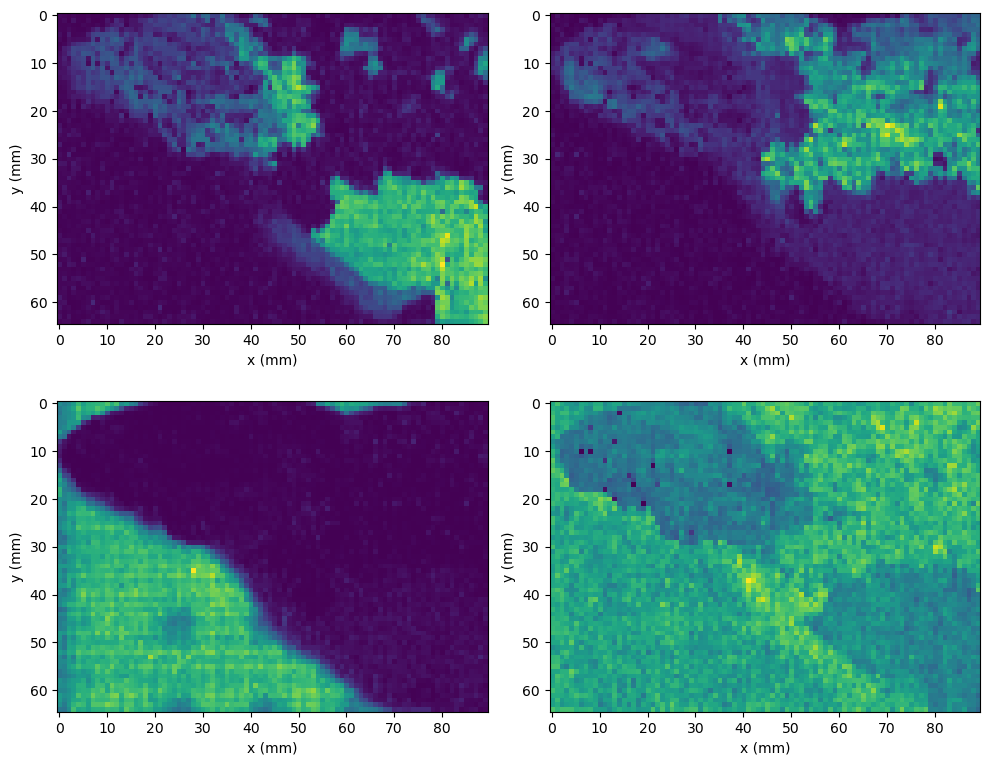

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 4)
a=kmeans.fit_predict(maps_without_background)
labels = kmeans.labels_
fig, ax = subplots(2, 2,figsize=(10,8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(maps_without_background_1.shape[1], maps_without_background_1.shape[2]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 2:
        j = 0
        l += 1

fig.tight_layout()

In [ ]:
def generate_square_mask(rows, cols, square_size, alternating=True):
    mask = np.zeros((rows, cols))
    value = 1 if alternating else 0
    for i in range(0, rows, square_size):
        for j in range(0, cols, square_size*2):
            mask[i:i+square_size, j:j+square_size] = value
            value = 1 - value  # Toggle between 0 and 1
    return mask
def generate_line_mask(rows, cols, line_length, is_horizontal=True):
    mask = np.zeros((rows, cols))
    start = 0 if is_horizontal else (cols - line_length) // 2
    end = start + line_length
    mask[start:end, :] = 1 if is_horizontal else 1
    return mask

def visualize_mask(mask):
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.show()


In [ ]:
cluster_init_masks=[]
for i in [50,100,150,200]:
    chess_mask=generate_line_mask(maps_without_background_1.shape[1],maps_without_background_1.shape[2],i)
    visualize_mask(chess_mask)
    cluster_init_masks.append(chess_mask.reshape(maps_without_background_1.shape[1]*maps_without_background_1.shape[2]))


In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 4,init=cluster_init_masks)
a=kmeans.fit_predict(maps_without_background)
labels = kmeans.labels_
fig, ax = subplots(2, 3,figsize=(10,8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(maps_without_background_1.shape[1], maps_without_background_1.shape[2]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

In [ ]:
def vertical_grid(nrows, ncols, l, first_n):
    matrix = np.zeros([nrows, ncols])
    lines = 0
    
    while first_n < ncols:
        matrix[:, first_n:first_n + l] = 1
        first_n += 2 * l
        lines += 1

    return matrix



In [ ]:
nrows = maps_without_background_1.shape[2]
ncols = maps_without_background_1.shape[1]
l = 40
first_n = 100

result_matrix = vertical_grid(nrows, ncols, l, first_n)
imshow(result_matrix)

In [ ]:
cluster_init_masks=[]
nrows = maps_without_background_1.shape[2]
ncols = maps_without_background_1.shape[1]



for i in [0,30,50,100,150]:
    chess_mask=vertical_grid(nrows,ncols,40,i)
    visualize_mask(chess_mask)
    cluster_init_masks.append(chess_mask.reshape(maps_without_background_1.shape[1]*maps_without_background_1.shape[2]).T)


In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5,init=cluster_init_masks)
a=kmeans.fit_predict(maps_without_background)
labels = kmeans.labels_
fig, ax = subplots(2, 3,figsize=(10,8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(maps_without_background_1.shape[1], maps_without_background_1.shape[2]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

In [ ]:
def custom_chess_grid(nrows, ncols, square_height, square_length):
    matrix = np.zeros([nrows, ncols])

    for i in range(0, nrows, 2 * square_height):
        for j in range(0, ncols, 2 * square_length):
            matrix[i:i + square_height, j:j + square_length] = 1
            matrix[i + square_height:i + 2 * square_height, j + square_length:j + 2 * square_length] = 1

    return matrix

In [ ]:
cluster_init_masks=[]
nrows = maps_without_background_1.shape[2]
ncols = maps_without_background_1.shape[1]

chess_mask=custom_chess_grid(nrows,ncols,50,50)
visualize_mask(chess_mask)
chess_mask=custom_chess_grid(nrows,ncols,10,10)
visualize_mask(chess_mask)


for i in [10,20,30,40]:
    chess_mask=custom_chess_grid(nrows,ncols,i,i)
    visualize_mask(chess_mask)
    cluster_init_masks.append(chess_mask.reshape(maps_without_background_1.shape[1]*maps_without_background_1.shape[2]).T)


In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 4,init=cluster_init_masks)
a=kmeans.fit_predict(maps_without_background)
labels = kmeans.labels_
fig, ax = subplots(2, 2,figsize=(10,8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(maps_without_background_1.shape[1], maps_without_background_1.shape[2]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 2:
        j = 0
        l += 1

fig.tight_layout()

In [ ]:
fig,ax=subplots(1,5,figsize=(12,5))

for i in range(len(significant_w)):
    ax[i].imshow(mask_min_max[significant_w[i]].reshape(250,100).T)

In [ ]:
fig,ax=subplots(1,4)
initial_mask=np.zeros([maps_without_background_1.shape[2],maps_without_background_1.shape[1]]).T
mask_albite=initial_mask.copy()
mask_albite[0:100,:]=np.ones([100,maps_without_background_1.shape[2]])
ax[0].imshow(mask_albite)

mask_spodumene=initial_mask.copy()
mask_spodumene[60:120,:]=np.ones([60,maps_without_background_1.shape[2]])
mask_spodumene[170:,:]=np.ones([maps_without_background_1.shape[1]-170,maps_without_background_1.shape[2]])
ax[1].imshow(mask_spodumene)


mask_petalite=initial_mask.copy()
mask_petalite[70:,:]=np.ones([maps_without_background_1.shape[1]-70,maps_without_background_1.shape[2]])
ax[2].imshow(mask_petalite)


mask_quartz=initial_mask.copy()
mask_quartz[130:150,:]=np.ones([150-130,maps_without_background_1.shape[2]])
ax[3].imshow(mask_quartz)


In [ ]:
init_masks=[mask_albite.flatten().T,mask_spodumene.flatten().T,mask_petalite.flatten().T,mask_quartz.flatten().T]


In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 4,init=init_masks)
a=kmeans.fit_predict(maps_without_background)
labels = kmeans.labels_
fig, ax = subplots(2, 2,figsize=(10,8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(maps_without_background_1.shape[1], maps_without_background_1.shape[2]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 2:
        j = 0
        l += 1

fig.tight_layout()

In [ ]:
chess_mask=custom_chess_grid(nrows,ncols,10,10)
visualize_mask(chess_mask)
line_mask=custom_chess_grid(nrows,ncols,200,10)
visualize_mask(line_mask)
hline_mask=custom_chess_grid(nrows,ncols,10,250)
visualize_mask(hline_mask)
large_chess_mask=custom_chess_grid(nrows,ncols,10,50)
visualize_mask(large_chess_mask)

#different_masks=[chess_mask.flatten(),line_mask.flatten(),hline_mask.flatten(),large_chess_mask.flatten()]
different_masks=[chess_mask.flatten(),line_mask.flatten(),hline_mask.flatten(),diagonal_grid.flatten()]

In [ ]:
small_mask=custom_chess_grid(nrows,ncols,1,1)
visualize_mask(small_mask)

In [ ]:
print(np.array(init_masks).shape)
print(np.array(different_masks).shape)

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 4,init=different_masks)
a=kmeans.fit_predict(maps_without_background)
labels = kmeans.labels_
fig, ax = subplots(2, 2,figsize=(10,8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(maps_without_background_1.shape[1], maps_without_background_1.shape[2]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 2:
        j = 0
        l += 1

fig.tight_layout()

In [ ]:
chess_mask=custom_chess_grid(nrows,ncols,10,10)
visualize_mask(chess_mask)
line_mask=custom_chess_grid(nrows,ncols,200,10)
visualize_mask(line_mask)
hline_mask=custom_chess_grid(nrows,ncols,10,250)
visualize_mask(hline_mask)
large_chess_mask=custom_chess_grid(nrows,ncols,10,50)
visualize_mask(large_chess_mask)



small_mask=custom_chess_grid(nrows,ncols,1,1)

different_masks=[chess_mask.flatten(),line_mask.flatten(),hline_mask.flatten(),large_chess_mask.flatten(),small_mask.flatten()]

In [ ]:
def custom_diagonal_grid(nrows, ncols, square_size):
    matrix = np.zeros([nrows, ncols])

    for i in range(0, nrows, square_size):
        matrix[i:i + square_size, i:i + square_size] = 1
        
    for i in range(0, nrows, square_size):
        matrix[i:i + square_size, i+100:i+100 + square_size] = 1
    for i in range(0, nrows, square_size):
        matrix[i:i + square_size, i+50:i+50 + square_size] = 1

    return matrix
nrows = maps_without_background_1.shape[2]
ncols = maps_without_background_1.shape[1]
diagonal_grid = custom_diagonal_grid(nrows, ncols, 10)
visualize_mask(diagonal_grid)

In [ ]:
ncols


In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5,init=different_masks)
a=kmeans.fit_predict(maps_without_background)
labels = kmeans.labels_
fig, ax = subplots(2, 3,figsize=(10,8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(maps_without_background_1.shape[1], maps_without_background_1.shape[2]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

## só as mascáras sem usar a entropia

In [ ]:
#entropy_masks=np.array([mask_min_max[i,:]*255 for i in range(297)])
entropy_masks=mask_min_max.copy()
entropy_masks_resh=entropy_masks.reshape(-1,250,100)
#cortar o background
maps_without_background_1=entropy_masks_resh[:,5:220,7:75]
maps_without_background=maps_without_background_1.reshape(maps_without_background_1.shape[0],maps_without_background_1.shape[1]*maps_without_background_1.shape[2])

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 4,init=different_masks)
a=kmeans.fit_predict(maps_without_background)
labels = kmeans.labels_
fig, ax = subplots(2, 2,figsize=(10,8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(maps_without_background_1.shape[1], maps_without_background_1.shape[2]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 2:
        j = 0
        l += 1

fig.tight_layout()

# OLD

## classificação a usar todos os mapas com entropias equalizadas

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 6)
a=kmeans.fit_predict(final_masks)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

## cortar primeiro os mapas com entropias fora das zonas e depois fazer a equalização

In [ ]:
relevant_entropies=[]
for i in significant_w:
    relevant_entropies.append(image_entropy[i])
    
max_en=np.max(relevant_entropies)
min_en=np.min(relevant_entropies)

new_maps_cut=[]
for i in range(entropy_masks.shape[0]):
    if min_en<=image_entropy[i]<=max_en:
        new_maps_cut.append(entropy_masks[i,:])
        
new_maps_cut=np.array(new_maps_cut)


In [ ]:
#P=new_maps_cut.mean(axis=0)
P=np.random.random(25000)
#sorted_args=P.argsort()
P.sort()
final_masks=[]
for i in range(new_maps_cut.shape[0]):
    X=new_maps_cut[i].copy()
    #X.sort()
    sorted_args=X.argsort()
    new_X=np.ones(new_maps_cut.shape[1])
    for j in range(new_maps_cut.shape[1]):
        #new_X[j]=float(P[sorted_args[j]])
        new_X[sorted_args[j]]=P[j]
        
    #print(new_X)
    final_masks.append(new_X)
    
final_masks=np.array(final_masks)*255

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 4)
a=kmeans.fit_predict(final_masks)
labels = kmeans.labels_
fig, ax = subplots(2, 2, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 2:
        j = 0
        l += 1

fig.tight_layout()